In [ ]:
# !git clone https://github.com/Ariel5/omp-parallel-gpu-python

In [ ]:
"""To profile the running time line-by-line. CUDA needs to run synchronously. Set this to 1 to do that"""
%env CUDA_LAUNCH_BLOCKING=0

env: CUDA_LAUNCH_BLOCKING=0


In [ ]:
%load_ext Cython

In [ ]:
%%cython

"""Cython allows us to call lower level c-code instead of using Python. It can be a surprisingly big speedup!"""
import cython
from scipy.linalg.cython_blas cimport idamax, isamax, daxpy, dgemv, dtrmv, dcopy
from scipy.linalg.cython_lapack cimport dposv, dppsv, sppsv

ctypedef fused proj_t:
    double
    float

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void ppsv(proj_t[:, :] As,
           proj_t[:, :, :] ys) nogil:
    # Works not for strided array I think. And please do not give a negative-stride array.
    cdef Py_ssize_t B = ys.shape[0]  # Batch size
    cdef int N = ys.shape[1]
    cdef int nrhs = ys.shape[2]
    cdef int info = 0  # Just discard any error signals ;)
    cdef char uplo = 85 # The letter 'U', since we store the lower triangle and fortran sees As.T.
    # cdef int ldb = ys[0].strides[0] // sizeof(double)

    for i from 0 <= i < B:
        if proj_t is double:  # One C-function is created for each of these specializations! :) (see argmax_blast.__signatures__)
            dppsv(&uplo, &N, &nrhs, &As[i, 0], &ys[i, 0, 0], &N, &info)
        elif proj_t is float:
            sppsv(&uplo, &N, &nrhs, &As[i, 0], &ys[i, 0, 0], &N, &info)


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef void argmax_blast(proj_t[:, :] projections,
                 long long[:] output) nogil:
    # TODO: Numpy has its own indexing data-type - this may be a more appropriate output, and may even be faster.
    # http://conference.scipy.org/static/wiki/seljebotn_cython.pdf
    # https://apprize.best/python/cython/3.html
    cdef Py_ssize_t B = projections.shape[0]
    cdef int N = projections.shape[1]
    cdef int incx = projections.strides[1] // sizeof(proj_t)  # Stride between elements.
    cdef Py_ssize_t i
    for i from 0 <= i < B:
        if proj_t is double:
            output[i] = idamax(&N, &projections[i, 0], &incx) - 1
        elif proj_t is float:
            output[i] = isamax(&N, &projections[i, 0], &incx) - 1

In [ ]:
"""For profiling how long each line takes, both on CPU and GPU (needs synchronization)"""
!pip install line_profiler
%load_ext line_profiler
!git clone https://github.com/NVIDIA/PyProf.git
!pip install ./PyProf

In [ ]:
"""This cell contains the code we've implemented. You should be able to call each function directly, or alternatively, see our example calls below"""

import os
import torch
import torch.utils
import torch.utils.data
from sklearn.datasets import make_sparse_coded_signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from contextlib import contextmanager
from timeit import default_timer
# from test_omp import omp_naive
# from test import *  # FIXME: better name
from line_profiler import line_profiler

n_components, n_features = 100, 100
n_nonzero_coefs = 17
n_samples = 50

@contextmanager
def elapsed_timer():
    # https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start


def run_omp(X, y, n_nonzero_coefs, precompute=True, tol=0.0, normalize=False, fit_intercept=False, alg='naive'):
    if not isinstance(X, torch.Tensor):
        X = torch.as_tensor(X)
        y = torch.as_tensor(y)

    # We can either return sets, (sets, solutions), or xests
    # These are all equivalent, but are simply more and more dense representations.
    # Given sets and X and y one can (re-)construct xests. The second is just a sparse vector repr.

    # https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L690
    if fit_intercept or normalize:
        X = X.clone()
        assert not isinstance(precompute, torch.Tensor), "If user pre-computes XTX they can also pre-normalize X" \
                                                         " as well, so normalize and fit_intercept must be set false."

    if fit_intercept:
        X = X - X.mean(0)
        y = y - y.mean(1)[:, None]

    # To keep a good condition number on X, especially with Cholesky compared to LU factorization,
    # we should probably always normalize it (OMP is invariant anyways)
    if normalize is True:  # User can also just optionally supply pre-computed norms.
        normalize = (X * X).sum(0).sqrt()
        X /= normalize[None, :]

    if precompute is True or alg == 'v0':
        precompute = X.T @ X

    # If n_nonzero_coefs is equal to M, one should just return lstsq
    if alg == 'naive':
        sets, solutions, lengths = omp_naive(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)
    elif alg == 'v0':
        sets, solutions, lengths = omp_v0(X, y, n_nonzero_coefs=n_nonzero_coefs, XTX=precompute, tol=tol)


    solutions = solutions.squeeze(-1)
    if normalize is not False:
        solutions /= normalize[sets]

    xests = y.new_zeros(y.shape[0], X.shape[1])
    if lengths is None:
        xests[torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)[:, None], sets] = solutions
    else:
        for i in range(y.shape[0]):
            # xests[i].scatter_(-1, sets[i, :lengths[i]], solutions[i, :lengths[i]])
            xests[i, sets[i, :lengths[i]]] = solutions[i, :lengths[i]]

    return xests

def batch_mm(matrix, matrix_batch, return_contiguous=True):
    """
    :param matrix: Sparse or dense matrix, size (m, n).
    :param matrix_batch: Batched dense matrices, size (b, n, k).
    :return: The batched matrix-matrix product, size (m, n) x (b, n, k) = (b, m, k).
    """
    # One dgemm is faster than many dgemv.
    # From https://github.com/pytorch/pytorch/issues/14489#issuecomment-607730242
    batch_size = matrix_batch.shape[0]
    # Stack the vector batch into columns. (b, n, k) -> (n, b, k) -> (n, b*k)
    vectors = matrix_batch.transpose([1, 0, 2]).reshape(matrix.shape[1], -1)

    # A matrix-matrix product is a batched matrix-vector product of the columns.
    # And then reverse the reshaping. (m, n) x (n, b*k) = (m, b*k) -> (m, b, k) -> (b, m, k)
    if return_contiguous:
        result = np.empty_like(matrix_batch, shape=(batch_size, matrix.shape[0], matrix_batch.shape[2]))
        np.matmul(matrix, vectors, out=result.transpose([1, 0, 2]).reshape(matrix.shape[0], -1))
    else:
        result = (matrix @ vectors).reshape(matrix.shape[0], batch_size, -1).transpose([1, 0, 2])

    return result


def innerp(x, y=None, out=None):
    if y is None:
        y = x
    if out is not None:
        out = out[:, None, None]  # Add space for two singleton dimensions.
    return torch.matmul(x[..., None, :], y[..., :, None], out=out)[..., 0, 0]

def cholesky_solve(ATA, ATy):
    if ATA.dtype == torch.half or ATy.dtype == torch.half:
        return ATy.to(torch.float).cholesky_solve(torch.cholesky(ATA.to(torch.float))).to(ATy.dtype)
    return ATy.cholesky_solve(torch.cholesky(ATA)).to(ATy.dtype)


def omp_naive(X, y, n_nonzero_coefs, tol=None, XTX=None):
    on_cpu = not (y.is_cuda or y.dtype == torch.half)
    # torch.cuda.synchronize()
    # Given X as an MxN array and y as an BxN array, do omp to approximately solve Xb=y

    # Base variables
    XT = X.contiguous().t()  # Store XT in fortran-order.
    y = y.contiguous()
    r = y.clone()

    sets = y.new_zeros((n_nonzero_coefs, y.shape[0]), dtype=torch.long).t()
    if tol:
        result_sets = sets.new_zeros(y.shape[0], n_nonzero_coefs)
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        original_indices = torch.arange(y.shape[0], dtype=sets.dtype, device=sets.device)

    # Trade b*k^2+bk+bkM = O(bkM) memory for much less compute time. (This has to be done anyways since we are batching,
    # otherwise one could just permute columns of X in-place as in https://github.com/scikit-learn/scikit-learn/blob/15a949460dbf19e5e196b8ef48f9712b72a3b3c3/sklearn/linear_model/_omp.py#L28 )
    ATs = y.new_zeros(r.shape[0], n_nonzero_coefs, X.shape[0])
    ATys = y.new_zeros(r.shape[0], n_nonzero_coefs, 1)
    ATAs = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device)[None].repeat(r.shape[0], 1, 1)
    if on_cpu:
        # For CPU it is faster to use a packed representation of the lower triangle in ATA.
        tri_idx = torch.tril_indices(n_nonzero_coefs, n_nonzero_coefs, device=sets.device, dtype=sets.dtype)
        ATAs = ATAs[:, tri_idx[0], tri_idx[1]]

    solutions = y.new_zeros((r.shape[0], 0))

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = innerp(r) <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                remaining = ~problems_done

                orig_idxs = original_indices[problems_done]
                result_sets[orig_idxs, :k] = sets[problems_done, :k]
                result_solutions[orig_idxs, :k] = solutions[problems_done]
                result_lengths[orig_idxs] = k
                original_indices = original_indices[remaining]

                # original_indices = original_indices[remaining]
                ATs = ATs[remaining]
                ATys = ATys[remaining]
                ATAs = ATAs[remaining]
                sets = sets[remaining]
                y = y[remaining]
                r = r[remaining]
                if problems_done.all():
                    return result_sets, result_solutions, result_lengths
        # GET PROJECTIONS AND INDICES TO ADD
        if on_cpu:
            projections = batch_mm(XT.numpy(), r[:, :, None].numpy())
            argmax_blast(projections.squeeze(-1), sets[:, k].numpy())
        else:
            projections = XT @ r[:, :, None]
            sets[:, k] = projections.abs().sum(-1).argmax(-1)  # Sum is just a squeeze, but would be relevant in SOMP.

        # UPDATE AT
        AT = ATs[:, :k + 1, :]
        updateA = XT[sets[:, k], :]
        AT[:, k, :] = updateA

        # UPDATE ATy based on AT
        ATy = ATys[:, :k + 1]
        innerp(updateA, y, out=ATy[:, k, 0])

        # UPDATE ATA based on AT or precomputed XTX.
        if on_cpu:
            packed_idx = k * (k - 1) // 2
            if XTX is not None:  # Update based on precomputed XTX.
                ATAs.t()[k + packed_idx:packed_idx + 2 * k + 1, :].t().numpy()[:] = XTX[sets[:, k, None], sets[:, :k + 1]]
            else:
                np.matmul(AT[:, :k + 1, :].numpy(), updateA[:, :, None].numpy(),
                          out=ATAs.t()[k + packed_idx:packed_idx + 2 * k + 1, :].t()[:, :, None].numpy())
        else:
            ATA = ATAs[:, :k + 1, :k + 1]
            if XTX is not None:
                ATA[:, k, :k + 1] = XTX[sets[:, k, None], sets[:, :k + 1]]
            else:
                # Update ATAs by adding the new column of inner products.
                torch.bmm(AT[:, :k + 1, :], updateA[:, :, None], out=ATA[:, k, :k + 1, None])

        # SOLVE ATAx = ATy.
        if on_cpu:
            solutions = ATy.permute(0, 2, 1).clone().permute(0, 2, 1)  # Get a copy.
            ppsv(ATAs.t()[:packed_idx + 2 * k + 1, :].t().contiguous().numpy(), solutions.numpy())
        else:
            ATA[:, :k, k] = ATA[:, k, :k]  # Copy lower triangle to upper triangle.
            solutions = cholesky_solve(ATA, ATy)

        # FINALLY, GET NEW RESIDUAL r=y-Ax
        if on_cpu:
            np.subtract(y.numpy(), (AT.permute(0, 2, 1).numpy() @ solutions.numpy()).squeeze(-1), out=r.numpy())
        else:
            torch.baddbmm(y[:, :, None], AT.permute(0, 2, 1), solutions, beta=-1, out=r[:, :, None])

    return sets, solutions, None

def omp_v0(X, y, XTX, n_nonzero_coefs=None, tol=None, inverse_cholesky=True):
    B = y.shape[0]
    normr2 = innerp(y)  # Norm squared of residual.
    projections = (X.transpose(1, 0) @ y[:, :, None]).squeeze(-1)
    sets = y.new_zeros(n_nonzero_coefs, B, dtype=torch.int64)

    if inverse_cholesky:
        # Doing the inverse-cholesky iteratively uses more memory,
        # but takes less time than waiting till solving the problem in the end it seems.
        # (Since F is triangular it could be __even faster__ to multiply, prob. not on GPU tho.)
        F = torch.eye(n_nonzero_coefs, dtype=y.dtype, device=y.device).repeat(B, 1, 1)
        a_F = y.new_zeros(n_nonzero_coefs, B, 1)

    D_mybest = y.new_empty(B, n_nonzero_coefs, XTX.shape[0])
    temp_F_k_k = y.new_ones((B, 1))

    if tol:
        result_lengths = sets.new_zeros(y.shape[0])
        result_solutions = y.new_zeros((y.shape[0], n_nonzero_coefs, 1))
        finished_problems = sets.new_zeros(y.shape[0], dtype=torch.bool)

    for k in range(n_nonzero_coefs+bool(tol)):
        # STOPPING CRITERIA
        if tol:
            problems_done = normr2 <= tol
            if k == n_nonzero_coefs:
                problems_done[:] = True

            if problems_done.any():
                new_problems_done = problems_done & ~finished_problems
                finished_problems.logical_or_(problems_done)
                result_lengths[new_problems_done] = k
                if inverse_cholesky:
                    result_solutions[new_problems_done, :k] = F[new_problems_done, :k, :k].permute(0, 2, 1) @ a_F[:k, new_problems_done].permute(1, 0, 2)
                else:
                    assert False, "inverse_cholesky=False with tol != None is not handled yet"
                if problems_done.all():
                    return sets.t(), result_solutions, result_lengths

        sets[k] = projections.abs().argmax(1)
        # D_mybest[:, k, :] = XTX[gamma[k], :]  # Same line as below, but significantly slower. (prob. due to the intermediate array creation)
        torch.gather(XTX, 0, sets[k, :, None].expand(-1, XTX.shape[1]), out=D_mybest[:, k, :])
        if k:
            D_mybest_maxindices = D_mybest.permute(0, 2, 1)[torch.arange(D_mybest.shape[0], dtype=sets.dtype, device=sets.device), sets[k], :k]
            torch.rsqrt(1 - innerp(D_mybest_maxindices),
                        out=temp_F_k_k[:, 0])  # torch.exp(-1/2 * torch.log1p(-inp), temp_F_k_k[:, 0])
            D_mybest_maxindices *= -temp_F_k_k  # minimal operations, exploit linearity
            D_mybest[:, k, :] *= temp_F_k_k
            D_mybest[:, k, :, None].baddbmm_(D_mybest[:, :k, :].permute(0, 2, 1), D_mybest_maxindices[:, :, None])


        temp_a_F = temp_F_k_k * torch.gather(projections, 1, sets[k, :, None])
        normr2 -= (temp_a_F * temp_a_F).squeeze(-1)
        projections -= temp_a_F * D_mybest[:, k, :]
        if inverse_cholesky:
            a_F[k] = temp_a_F
            if k:  # Could maybe get a speedup from triangular mat mul kernel.
                torch.bmm(D_mybest_maxindices[:, None, :], F[:, :k, :], out=F[:, k, None, :])
                F[:, k, k] = temp_F_k_k[..., 0]
    else: # FIXME: else branch will not execute if n_nonzero_coefs=0, so solutions is undefined.
        # Normal exit, used when tolerance=None.
        if inverse_cholesky:
            solutions = F.permute(0, 2, 1) @ a_F.squeeze(-1).transpose(1, 0)[:, :, None]
        else:
            # Solving the problem in the end without using inverse Cholesky.
            AT = X.T[sets.T]
            solutions = cholesky_solve(AT @ AT.permute(0, 2, 1), AT @ y.T[:, :, None])

    return sets.t(), solutions, None



In [ ]:
"""This is a helper function for allowing us to profile both GPU runtime as well as the time it takes to transfer to GPU memory"""
def gpu_transfer_and_alg(X,y, alg):
    X_gpu = torch.as_tensor(X, device='cuda', dtype=torch.float)
    y_gpu = torch.as_tensor(y, device='cuda', dtype=torch.float)
    results = run_omp(X_gpu, y_gpu, n_nonzero_coefs, alg=alg)
    results.cpu()

In [ ]:
"""Use this cell to profile line-by-line the algorithms you want to run"""

# from sklearn.datasets import make_sparse_coded_signal

# # m = 64
# # n_components, n_features = m*8, m
# # n_nonzero_coefs = m//4
# # n_samples = 200000


# # 20000 x 8000 x 1600 x 10 is just within memory reach on GPU
# n_components, n_features = 20000, 8000
# n_nonzero_coefs = 1600
# # Keep this above 1 not to mess with dimensions of y
# n_samples = 3

# # Out of memory on CPU if bigger than this
# # n_components, n_features = 20000, 8000
# # n_nonzero_coefs = 1000
# # n_samples = 10

# y, X, w = make_sparse_coded_signal(
#     n_samples=n_samples,
#     n_components=n_components,
#     n_features=n_features,
#     n_nonzero_coefs=n_nonzero_coefs,
#     random_state=0)

# y = y.T

# # Naive CPU
# # %lprun -f omp_naive run_omp(torch.as_tensor(X, device='cpu', dtype=torch.float), torch.as_tensor(y, device='cpu', dtype=torch.float), n_nonzero_coefs)
# # Naive GPU
# # %lprun -f omp_naive -f run_omp -f gpu_transfer_and_alg gpu_transfer_and_alg(X,y, "naive")


# # V0 CPU
# # %lprun -f omp_v0 run_omp(torch.as_tensor(X, device='cpu', dtype=torch.float), torch.as_tensor(y, device='cpu', dtype=torch.float), n_nonzero_coefs, alg="v0")
# # V0 GPU
# %lprun -f omp_v0 -f run_omp -f gpu_transfer_and_alg gpu_transfer_and_alg(X,y, "v0")

In [ ]:
"""Use this cell to get execution time as function of problem size"""

execution_times = {}
execution_times["sklearn"] = []
execution_times["naive_cpu"] = []
execution_times["v0_cpu"] = []
execution_times["naive_gpu"] = []
execution_times["v0_gpu"] = []


tol=0.1
k=0

# Big problems
n_samples = 100
# m_arr = [16, 20, 24, 32, 64, 128, 256, 512, 1024, 2048]
m_arr = [2048]

# Small problems
# n_samples = 75000

# m_arr = [8, 16, 24, 32, 64, 128]


for m in m_arr:
  n_components, n_features = m*8, m
  n_nonzero_coefs = m//4

  y, X, w = make_sparse_coded_signal(
    n_samples=n_samples,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=2)

  y = y.T

  # omp_args = dict(tol=tol, n_nonzero_coefs=n_nonzero_coefs-k, precompute=False, fit_intercept=True, normalize=True)
  # # Single core
  # print('Single core. Sklearn')
  # omp = OrthogonalMatchingPursuit(**omp_args)
  # with elapsed_timer() as elapsed:
  #     omp.fit(X, y.T)
  # execution_times["sklearn"].append(elapsed())

  # with elapsed_timer() as elapsed:
  #   run_omp(torch.as_tensor(X, device='cpu', dtype=torch.float), torch.as_tensor(y, device='cpu', dtype=torch.float), n_nonzero_coefs)
  # execution_times["naive_cpu"].append(elapsed())

  # with elapsed_timer() as elapsed:
  #   run_omp(torch.as_tensor(X, device='cpu', dtype=torch.float), torch.as_tensor(y, device='cpu', dtype=torch.float), n_nonzero_coefs, alg="v0")
  # execution_times["v0_cpu"].append(elapsed())

  with elapsed_timer() as elapsed:
    gpu_transfer_and_alg(X,y, "naive")
  execution_times["naive_gpu"].append(elapsed())

  # with elapsed_timer() as elapsed:
  #   gpu_transfer_and_alg(X,y, "v0")
  # execution_times["v0_gpu"].append(elapsed())


RuntimeError: ignored

In [ ]:
execution_times

In [ ]:
# Plot execution time as function of problem size

# m = 64
# n_components, n_features = m*8, m
# n_nonzero_coefs = m//4
n_samples = 100

tol=0.1
k=0

m_arr = [16, 32, 64, 128, 256, 512, 1024]

time_spent = []

for m in m_arr:
  n_components, n_features = m*8, m
  n_nonzero_coefs = m//4

  y, X, w = make_sparse_coded_signal(
    n_samples=n_samples,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0)

  y = y.T

  omp_args = dict(tol=tol, n_nonzero_coefs=n_nonzero_coefs-k, precompute=False, fit_intercept=True, normalize=True)
  # Single core
  print('Single core. Sklearn')
  omp = OrthogonalMatchingPursuit(**omp_args)
  with elapsed_timer() as elapsed:
      omp.fit(X, y.T)
  time_spent.append(elapsed())

execution_times["sklearn"] = time_spent

In [ ]:
"""This and the cells below are to help figure out what hardware COLAB has assigned to our current runtime. It is mostly for curiosity reasons"""
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed May 12 17:09:28 2021
Driver Version                            : 460.32.03
CUDA Version                              : 11.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : Tesla
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1562420004590
    GPU UUID                              : GPU-1d9112dd-1d14-a619-b072-1c490

In [ ]:
!lscpu | grep -E "Hz|cache|Core|Socket"

Core(s) per socket:  1
Socket(s):           1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
CPU MHz:             2199.998
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K


In [ ]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       13333560 kB


In [ ]:
from scipy.io import loadmat
yale_faces = loadmat("/content/CroppedYale_96_84_2414_subset.mat")
yale_faces
faces = yale_faces["faces"]
facecls = yale_faces["facecls"]
num_images = len(facecls)

In [ ]:
import numpy as np
np.shape(yale_faces["faces"][0,:,:])
height = np.shape(yale_faces["faces"][0,:,:])[0]
width = np.shape(yale_faces["faces"][0,:,:])[1]

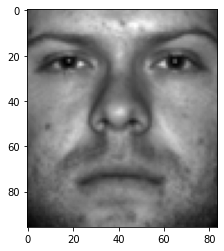

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(yale_faces["faces"][0,:,:], cmap="gray")

In [ ]:
# % Uniform sampling images to form training set
# % Split train and test 50-50
np.random.permutation(num_images)
training_set_indexes = np.random.permutation(num_images)[:num_images//2]
print(len(training_set_indexes))
test_set_indexes = np.random.permutation(num_images)[num_images//2:]
print(len(test_set_indexes))

training_set = faces[training_set_indexes,:,:]
labels_for_training_set = facecls[training_set_indexes]

1207
1207


In [ ]:
# % Forming giant A dictionary

# %double(imresize(Test_Image,[m1 n1]))
A = np.zeros((height*width, num_images//2));
# for tra_img in training_set:
for i in range(num_images//2):
    # print(np.shape(training_set(i,:,:)))
    col_img=np.reshape(training_set[i,:,:],(height*width, 1));
    # col_img = double(col_img);
    # A = np.hstack((A,col_img));
    A[:,i] = np.squeeze(col_img)
# disp("Size of A")
A

array([[ 67.,   2., 100., ...,   5.,  34.,  52.],
       [ 70.,   3., 102., ...,   5.,  30.,  55.],
       [ 72.,   3., 106., ...,   6.,  36.,  56.],
       ...,
       [ 20.,  51.,  15., ...,  59.,   0., 119.],
       [ 23.,  53.,  14., ...,   3.,   0., 108.],
       [ 33.,  53.,  13., ...,   5.,   0., 119.]])

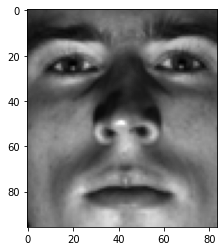

In [ ]:
# Make sure that the above transformatinos
plt.imshow(np.reshape(A[:,i], (height, width)), cmap="gray")

In [ ]:
from sklearn.preprocessing import normalize
norm_A = normalize(A, axis=1, norm='max')
norm_A

array([[0.2627451 , 0.00784314, 0.39215686, ..., 0.01960784, 0.13333333,
        0.20392157],
       [0.2745098 , 0.01176471, 0.4       , ..., 0.01960784, 0.11764706,
        0.21568627],
       [0.28235294, 0.01176471, 0.41568627, ..., 0.02352941, 0.14117647,
        0.21960784],
       ...,
       [0.07843137, 0.2       , 0.05882353, ..., 0.23137255, 0.        ,
        0.46666667],
       [0.09019608, 0.20784314, 0.05490196, ..., 0.01176471, 0.        ,
        0.42352941],
       [0.12941176, 0.20784314, 0.05098039, ..., 0.01960784, 0.        ,
        0.46666667]])

For now, test with the 200th test_set example
[-0.00035878 -0.01315918  0.01862758 ... -0.00164911 -0.01604111
 -0.0130533 ]
(1207,)
594
Predicted img class [13]
True img class [13]


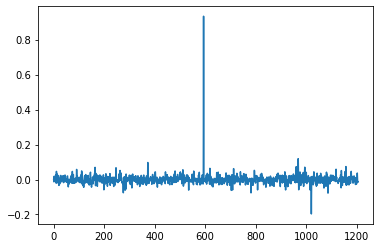

In [ ]:
# % Run algorithm for just 1 test image
from scipy.linalg import norm

print("For now, test with the 200th test_set example")
test_img_1 = faces[test_set_indexes[300],:,:]
# disp("Test image")
# plt.imshow(test_img_1, cmap="gray")
flat_test_img_1 = np.reshape(test_img_1,(height*width,1))
norm_flat = normalize(flat_test_img_1, axis=0, norm='max')
# flat_test_img_1 = double(flat_test_img_1);

x = run_omp(torch.as_tensor(norm_A, device='cpu', dtype=torch.float), torch.as_tensor(norm_flat.T, device='cpu', dtype=torch.float), 30)

# x = OMP(flat_test_img_1, A, 30);
# omp_args = dict(tol=1e-6, n_nonzero_coefs=30, precompute=False, fit_intercept=False, normalize=False)
# # Single core
# print('Single core. Sklearn')
# omp = OrthogonalMatchingPursuit(**omp_args)
# with elapsed_timer() as elapsed:
#     omp.fit(norm_A, norm_flat)
# execution_times["sklearn"].append(elapsed())

print(omp.coef_)
x = omp.coef_
print(np.shape(x))
plt.plot(x)
print(np.argmax(x))
print("Predicted img class", facecls[training_set_indexes[np.argmax(x)]])
print("True img class", facecls[test_set_indexes[300]])


# TODO Implement proper residual calculation
# residual_for_class = np.zeros((38,1));
# for class_number in range(1,39):
#     residual_for_class[class_number-1] = norm(flat_test_img_1 - A[:, np.squeeze(labels_for_training_set.T == class_number)] @ x[np.squeeze(labels_for_training_set.T == class_number)])

# # disp("Residual plot for first test image")
# plt.plot(range(1, 39), residual_for_class)
# [resid cls_pick] = min(residual_for_class);
# disp("Predicted image class: " + cls_pick);
# disp("True image class")
# facecls(test_set_indexes(1))

In [ ]:
# Batch all test images together, to make them ready for our algs.
test_images_batch = np.zeros((height*width, len(test_set_indexes)))
count = 0
for i in test_set_indexes:
  test_img_1 = faces[i,:,:]
  flat_test_img_1 = np.reshape(test_img_1,(height*width,1))
  norm_flat = normalize(flat_test_img_1, axis=0, norm='max')
  test_images_batch[:,count] = np.squeeze(norm_flat)
  count+=1
# flat_test_img_1 = double(flat_test_img_1);

In [ ]:
np.shape(test_images_batch)

(8064, 1207)

In [ ]:
# HW7 batched test images on Sklearn
omp_args = dict(tol=1e-6, n_nonzero_coefs=30, precompute=False, fit_intercept=False, normalize=False)

print('Single core. Sklearn')
omp = OrthogonalMatchingPursuit(**omp_args)
with elapsed_timer() as elapsed:
    omp.fit(norm_A, test_images_batch)
elapsed()

Single core. Sklearn


KeyboardInterrupt: ignored

In [ ]:
# HW7 batched test images on Naive
with elapsed_timer() as elapsed:
  xes = run_omp(torch.as_tensor(norm_A, device='cpu', dtype=torch.float), torch.as_tensor(test_images_batch.T, device='cpu', dtype=torch.float), 30)
elapsed()

13.090961750000133

In [ ]:
# HW7 batched test images on V0
with elapsed_timer() as elapsed:
  xes = run_omp(torch.as_tensor(norm_A, device='cpu', dtype=torch.float), torch.as_tensor(test_images_batch.T, device='cpu', dtype=torch.float), 30, alg="v0")
elapsed()

1.2141480640002555

In [ ]:
# HW7 batched test images on Naive GPU
with elapsed_timer() as elapsed:
  xes = run_omp(torch.as_tensor(norm_A, device='cuda', dtype=torch.float), torch.as_tensor(test_images_batch.T, device='cuda', dtype=torch.float), 30)
elapsed()

0.6089971310000237

In [ ]:
# HW7 batched test images on V0 GPU
with elapsed_timer() as elapsed:
  xes = run_omp(torch.as_tensor(norm_A, device='cuda', dtype=torch.float), torch.as_tensor(test_images_batch.T, device='cuda', dtype=torch.float), 30, alg="v0")
elapsed()

0.11103309200001377